# Imports

In [33]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from skimage.morphology import binary_dilation, binary_erosion

# Load Data

## MNIST

In [34]:
ds_mnist = tfds.load('mnist', split='train')
df_mnist = tfds.as_dataframe(ds_mnist)
print(f'{df_mnist.shape=}')
print(f"Image shape: {df_mnist['image'][0].shape}")

df_mnist.shape=(60000, 2)
Image shape: (28, 28, 1)


## Fashion MNIST

In [35]:
ds_fmnist = tfds.load('fashion_mnist', split='train')
df_fmnist = tfds.as_dataframe(ds_fmnist)
print(f'{df_fmnist.shape=}')
print(f"Image shape: {df_fmnist['image'][0].shape}")

df_fmnist.shape=(60000, 2)
Image shape: (28, 28, 1)


## EMNIST

In [36]:
# Takes about 15 mins
ds_emnist = tfds.load('emnist', split='train')
df_emnist = tfds.as_dataframe(ds_emnist)
print(f'{df_emnist.shape=}')
print(f"Image shape: {df_emnist['image'][0].shape}")

df_emnist.shape=(697932, 2)
Image shape: (28, 28, 1)


# Explore images

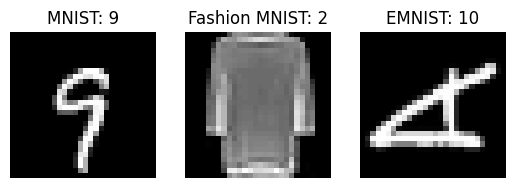

In [37]:
fig, axs = plt.subplots(ncols=3, nrows=1)

mnist = df_mnist['image'][100].squeeze()
mnist_title = df_mnist['label'][100]

fmnist = df_fmnist['image'][100].squeeze()
fmnist_title = df_fmnist['label'][100]

# The images are inverted horizontally and rotated 90 anti-clockwise
emnist = df_emnist['image'][100].squeeze()
emnist_title = df_emnist['label'][100]

axs[0].set_title(f'MNIST: {mnist_title}')
axs[0].axis('off')
axs[0].imshow(mnist, cmap='gray')

axs[1].set_title(f'Fashion MNIST: {fmnist_title}')
axs[1].axis('off')
axs[1].imshow(fmnist, cmap='gray')

axs[2].set_title(f'EMNIST: {emnist_title}')
axs[2].axis('off')
axs[2].imshow(emnist, cmap='gray')

plt.show();

# Remove labels

In [38]:
df_mnist['image'].dtype

dtype('O')

In [39]:
dfs = [df_mnist, df_fmnist, df_emnist]
arrs = []

for i in range(len(dfs)):
    arrs.append(
        np.array(
            dfs[i]['image'].tolist(),
            dtype='uint8'
        ).squeeze()
    )

arrs[0].shape

(60000, 28, 28)

# Binarize

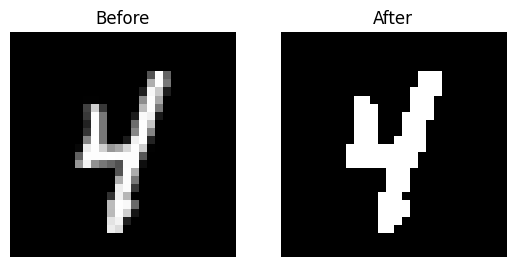

In [40]:
fig, axs = plt.subplots(ncols=2, nrows=1)

before = arrs[0][0]
after = np.where(arrs[0] > 0, 1, 0)[0]

axs[0].set_title('Before')
axs[0].axis('off')
axs[0].imshow(before, cmap='gray')

axs[1].set_title('After')
axs[1].axis('off')
axs[1].imshow(after, cmap='gray')

plt.show();

In [41]:
for i in range(len(arrs)):
    arrs[i] = np.where(arrs[i] > 0, 1, 0)

# Pattern matching :) !
arr_mnist, arr_fmnist, arr_emnist = arrs

# See results

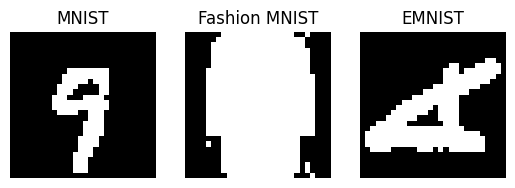

In [42]:
mnist = arr_mnist[100]
fmnist = arr_fmnist[100]
emnist = arr_emnist[100]

fig, axs = plt.subplots(ncols=3, nrows=1)

axs[0].set_title('MNIST')
axs[0].axis('off')
axs[0].imshow(mnist, cmap='gray')

axs[1].set_title('Fashion MNIST')
axs[1].axis('off')
axs[1].imshow(fmnist, cmap='gray')

axs[2].set_title('EMNIST')
axs[2].axis('off')
axs[2].imshow(emnist, cmap='gray')

plt.show();

# Sample from arrays

In [43]:
def print_batch(batch, title='Batch'):
    plt.figure(figsize=(15, 20))
    plt.title(title)
    plt.axis('off')
    
    if len(batch.shape) > 2:
        batch = np.hstack(batch)
    
    plt.imshow(batch, cmap='gray')
    


def get_batch_pics(num=10, seed=None):
    result = np.zeros((num, *arr_mnist.shape[1:]))

    np.random.seed(seed)
    arr_idxs = np.random.choice([0, 1, 2], size=num)
    pic_idxs = np.random.choice(range(df_mnist.shape[0]), size=num)

    for (i, (arr_idx, pic_idx)) in enumerate(zip(arr_idxs, pic_idxs)):
        result[i] = arrs[arr_idx][pic_idx]

    return result

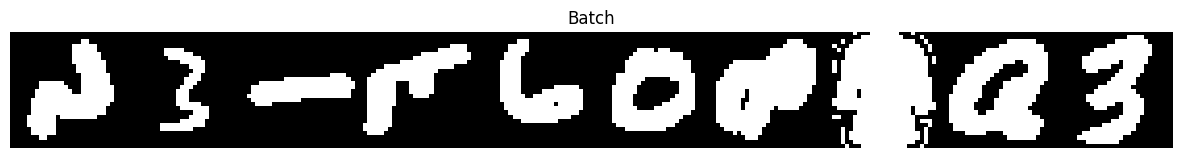

In [44]:
batch = get_batch_pics(seed=42)
print_batch(batch)

# Dilation

In [45]:
def dilate_binary(im, footprint):
    # Sadly, Python does not allow for a readable use of higher-order functions
    # list(map(lambda tup: (tup[0] // 28, tup[0] % 28), filter(lambda tup: tup[1] == 1, enumerate(batch[1].flatten()))))

    if footprint.shape[0] != footprint.shape[1] or footprint[footprint.shape[0] // 2, footprint.shape[1] // 2] != 1:
        raise ValueError('Footprint must be a square with 1 in its center!')

    im = im.astype(np.uint8)

    result = np.zeros_like(im, dtype=np.uint8)

    cols = im.shape[1]

    one_idx = [(i // cols, i % cols) for (i, val) in enumerate(im.flatten()) if val == 1]

    for (i, j) in one_idx:
        ii = i - 1
        jj = j - 1

        i_norm = (ii if ii > 0 else 0)
        j_norm = (jj if jj > 0 else 0)
        
        part = im[i_norm:ii+3, j_norm:jj+3]

        offset_i = i_norm - ii
        offset_j = j_norm - jj
        mask = footprint[offset_i : offset_i + part.shape[0], offset_j : part.shape[1]]

        result[i_norm:ii+3, j_norm:jj+3] = part | mask | result[i_norm:ii+3, j_norm:jj+3]

    return result

## Compare with `scikit-image`

In [46]:
footprint = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]], dtype = np.uint8)

# Single image (square matrix)
for im in batch:
    im_scikit = binary_dilation(im, footprint)
    im_simo = dilate_binary(im, footprint)
    print(np.all(im_scikit == im_simo))

# Multiple images (non-square matrix)
tmp_batch = np.hstack(batch)
im_scikit = binary_dilation(tmp_batch, footprint)
im_simo = dilate_binary(tmp_batch, footprint)
print(np.all(im_scikit == im_simo))

# Save to files to inspect
concatted = np.concatenate([tmp_batch, im_scikit, im_simo], axis=1).astype(np.uint8)
np.savetxt("array.txt", concatted, fmt='%d', delimiter='')

True
True
True
True
True
True
True
True
True
True
True


# Erosion

In [47]:
def erode_binary(im, footprint):
    if footprint.shape[0] != footprint.shape[1] or footprint[footprint.shape[0] // 2, footprint.shape[1] // 2] != 1:
        raise ValueError('Footprint must be a square with 1 in its center!')

    im = im.astype(np.uint8)

    result = np.zeros_like(im, dtype=np.uint8)

    cols = im.shape[1]

    one_idx = [(i // cols, i % cols) for (i, val) in enumerate(im.flatten()) if val == 1]

    for (i, j) in one_idx:
        ii = i - 1
        jj = j - 1

        i_norm = (ii if ii > 0 else 0)
        j_norm = (jj if jj > 0 else 0)
        
        part = im[i_norm:ii+3, j_norm:jj+3]

        offset_i = i_norm - ii
        offset_j = j_norm - jj
        mask = footprint[offset_i : offset_i + part.shape[0], offset_j : part.shape[1]]

        if np.all(part == mask):
            result[i, j] = 1

    return result

## Compare with `scikit-image`

In [48]:
footprint = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]], dtype = np.uint8)

# Single image (square matrix)
for im in batch:
    im_scikit = binary_erosion(im, footprint)
    im_simo = erode_binary(im, footprint)
    print(np.all(im_scikit == im_simo))

# Multiple images (non-square matrix)
tmp_batch = np.hstack(batch)
im_scikit = binary_erosion(tmp_batch, footprint)
im_simo = erode_binary(tmp_batch, footprint)
print(np.all(im_scikit == im_simo))

# Save to files to inspect
concatted = np.concatenate([tmp_batch, im_scikit, im_simo], axis=1).astype(np.uint8)
np.savetxt("array.txt", concatted, fmt='%d', delimiter='')

True
True
True
True
True
True
True
True
True
True
True


# Geodesic Dilation

In [49]:
def geodesic_dilation(mask, marker):
    footprint = np.array([[1, 1, 1],
                          [1, 1, 1],
                          [1, 1, 1]], dtype = np.uint8)

    result = dilate_binary(marker, footprint).astype(bool) & mask
    return result

# Geodesic Erosion

In [50]:
def geodesic_erosion(mask, marker):
    footprint = np.array([[1, 1, 1],
                          [1, 1, 1],
                          [1, 1, 1]], dtype = np.uint8)

    result = erode_binary(marker, footprint) | mask
    return result

# Morphological Reconstruction

In [51]:
mask = np.array([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
    [0,0,0,1,1,1,0,0,0,0],
    [0,0,0,1,0,1,0,0,0,0],
    [0,0,0,1,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
])
marker = np.array([
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
])

In [52]:
def morphological_reconstruction_dilation(mask, marker):
    step0 = marker.copy()

    while True:
        step1 = geodesic_dilation(mask, step0)
        step2 = geodesic_dilation(mask, step1)

        if np.all(step1 == step2):
            break

        step0 = step2

    return step1

In [53]:
morphological_reconstruction_dilation(mask, marker)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# Application 1: Remove objects specified by user

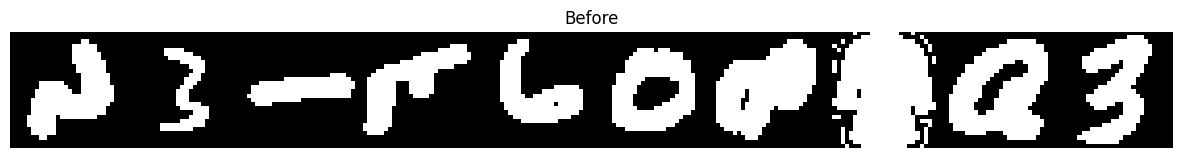

In [54]:
mask = np.hstack(batch).astype(np.uint8)
print_batch(mask, 'Before')
np.savetxt("start.txt", mask, fmt='%d', delimiter='')

In [55]:
marker = np.zeros_like(mask)
marker[23, 37] = 1
marker[3, 242] = 1

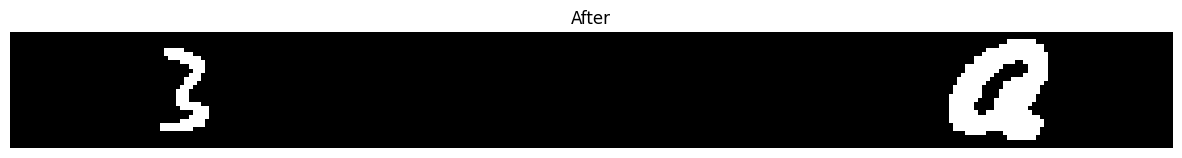

In [56]:
res = morphological_reconstruction_dilation(mask, marker)
print_batch(res, 'After')
np.savetxt("end.txt", res, fmt='%d', delimiter='')